In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv(r"C:\Users\fluca\Desktop\Data Science\Projetos\previsao_cba\data\Cesta_basica.csv")

In [3]:
df.tail()

,ano,mes,Custo
66,2024,mai,655.32
67,2024,jun,656.62
68,2024,jul,622.37
69,2024,ago,599.60
70,2024,set,618.13


In [4]:
# Criando um dicionário para mapear os meses para números
mes_dict = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 
            'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

# Convertendo o mês para um número usando o dicionário
df['mes_num'] = df['mes'].map(mes_dict)

df.head()

,ano,mes,Custo,mes_num
0,2018,out,347.49,10
1,2018,nov,351.80,11
2,2018,dez,351.44,12
3,2019,fev,353.35,2
4,2019,mar,378.80,3


In [5]:
# Excluindo as três primeiras linhas
df = df.iloc[3:].reset_index(drop=True)

# Excluindo as duas primeiras colunas ('ano' e 'mes')
df = df.drop(['mes'], axis=1)

In [6]:
# Reorganizando as colunas
df = df[['ano', 'mes_num', 'Custo']]
df.head()

,ano,mes_num,Custo
0,2019,2,353.35
1,2019,3,378.80
2,2019,4,382.63
3,2019,5,366.59
4,2019,6,377.44


In [7]:
# Renomeando as colunas
df = df.rename(columns={'mes_num': 'mes', 'Custo': 'cba'})
df.head()

,ano,mes,cba
0,2019,2,353.35
1,2019,3,378.80
2,2019,4,382.63
3,2019,5,366.59
4,2019,6,377.44


In [8]:
# Convertendo os dados da coluna 'cba' para numéricos
df['cba'] = pd.to_numeric(df['cba'], errors='coerce')

In [9]:
# Criando a coluna 'data' no formato 'YYYY-MM-DD'
df['data'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str) + '-01')

# Filtrando os dados a partir de 2020
df_2019 = df[df['data'] >= '2019-01-01']

# Reorganizando as colunas
df_2019 = df_2019[['data', 'cba']]

# Reiniciando os índices
df_2019.reset_index(drop=True, inplace=True)

df_2019.head()

,data,cba
0,2019-02-01,353.35
1,2019-03-01,378.80
2,2019-04-01,382.63
3,2019-05-01,366.59
4,2019-06-01,377.44


## SARIMA

In [10]:
 # Convertendo a coluna de data para datetime e definindo 'data' como índice
df_2019['data'] = pd.to_datetime(df_2019['data']) 
df_2019.set_index('data', inplace=True)  

# Série temporal da Cesta Básica de Alimentos (CBA)
cba_serie_temporal_2019 = df_2019['cba']

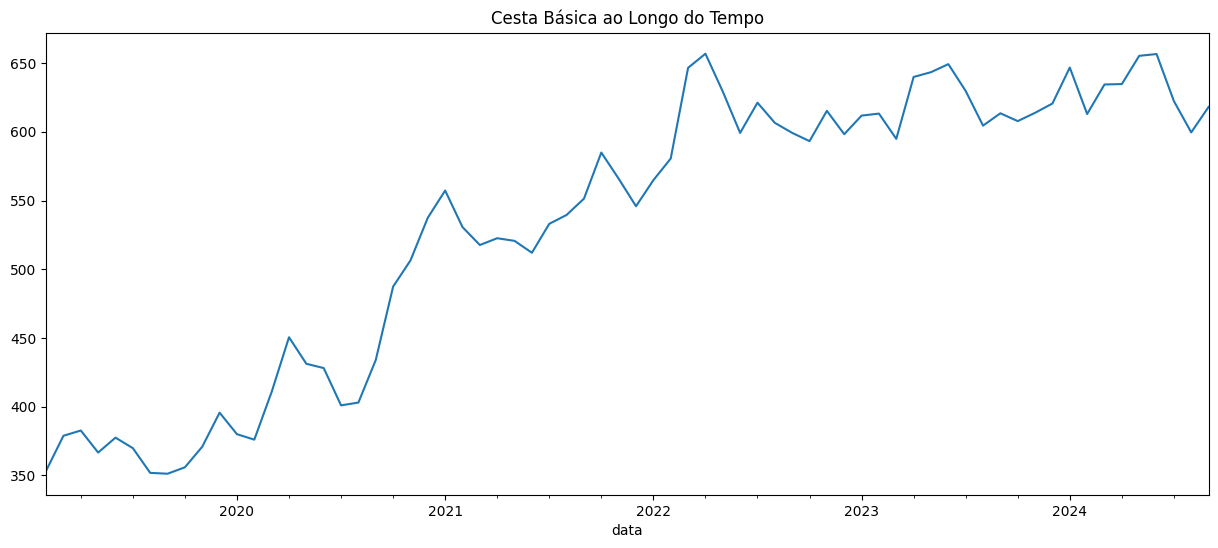

In [18]:
df_2019['cba'].plot(title='Cesta Básica ao Longo do Tempo', figsize=(15,6))
plt.show()

In [12]:
# Definindo os parâmetros SARIMA e para ARIMA para sazonalidade com período de 12 meses
sarima_model = SARIMAX(cba_serie_temporal_2019, 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 12))

# Ajustando o modelo
sarima_fitted = sarima_model.fit(disp=False)

c:\Users\fluca\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\fluca\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [13]:
# Fazendo previsões para os próximos 12 meses
previsoes = sarima_fitted.get_forecast(steps=12)

# Obtendo os intervalos de confiança (nível de confiança de 95%)
intervalos_de_confianca = previsoes.conf_int()

# Exibir as previsões e intervalos de confiança
print(previsoes.predicted_mean)  # Previsões de ponto
print(intervalos_de_confianca)   # Intervalos de confiança


2024-10-01    637.871661
2024-11-01    648.805089
2024-12-01    655.712208
2025-01-01    669.648648
2025-02-01    663.283583
2025-03-01    684.245769
2025-04-01    704.255873
2025-05-01    697.542125
2025-06-01    694.543306
2025-07-01    689.674080
2025-08-01    679.449375
2025-09-01    690.549960
Freq: MS, Name: predicted_mean, dtype: float64
             lower cba   upper cba
2024-10-01  594.578166  681.165157
2024-11-01  588.611806  708.998373
2024-12-01  583.189307  728.235108
2025-01-01  587.217103  752.080194
2025-02-01  572.509838  754.057328
2025-03-01  586.587276  781.904261
2025-04-01  600.548460  807.963286
2025-05-01  588.446850  806.637399
2025-06-01  580.596199  808.490413
2025-07-01  571.317680  808.030480
2025-08-01  557.053913  801.844837
2025-09-01  564.428229  816.671691


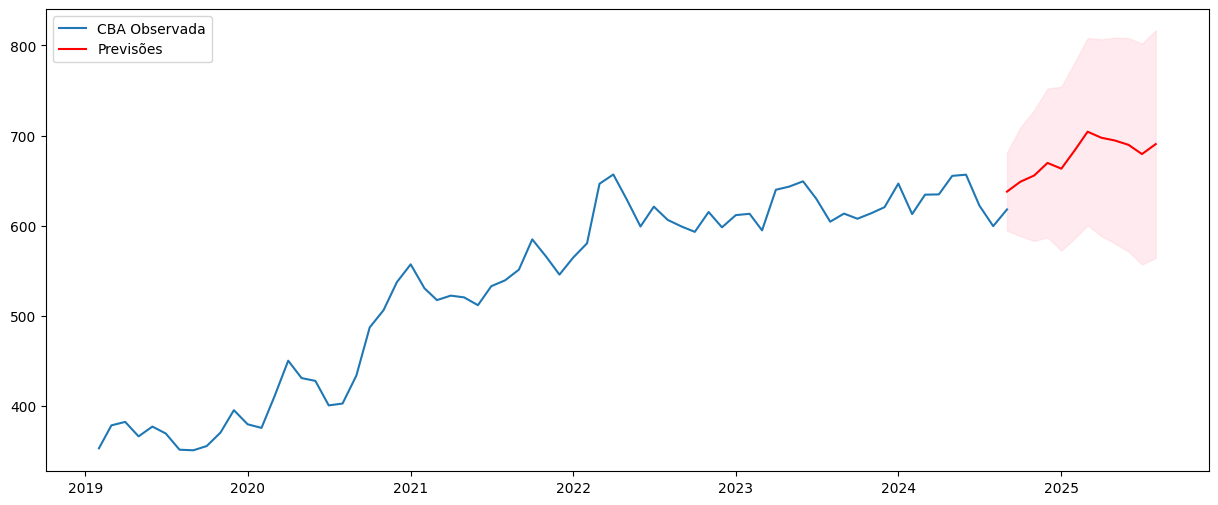

In [22]:
# Criando datas para o período previsto
datas_futuras = pd.date_range(start=df_2019.index[-1], periods=12, freq='MS')

plt.figure(figsize=(15,6))

plt.plot(df_2019.index, cba_serie_temporal_2019, label='CBA Observada')

plt.plot(datas_futuras, previsoes.predicted_mean, label='Previsões', color='red')

plt.fill_between(datas_futuras, 
                 intervalos_de_confianca.iloc[:, 0], 
                 intervalos_de_confianca.iloc[:, 1], 
                 color='pink', alpha=0.3)

plt.legend()
plt.show()


In [15]:
# Fazendo previsões para os próximos 12 meses
previsoes = sarima_fitted.get_forecast(steps=12)

# Obtendo os intervalos de confiança (nível de confiança de 95%)
intervalos_de_confianca = previsoes.conf_int()

# Criando um DataFrame com as previsões e intervalos de confiança
df_previsoes = pd.DataFrame({
    'cba': previsoes.predicted_mean,  # Previsões de ponto
    'lower_cba': intervalos_de_confianca.iloc[:, 0],  # Limite inferior
    'upper_cba': intervalos_de_confianca.iloc[:, 1]   # Limite superior
})

print(df_previsoes)

                   cba   lower_cba   upper_cba
2024-10-01  637.871661  594.578166  681.165157
2024-11-01  648.805089  588.611806  708.998373
2024-12-01  655.712208  583.189307  728.235108
2025-01-01  669.648648  587.217103  752.080194
2025-02-01  663.283583  572.509838  754.057328
2025-03-01  684.245769  586.587276  781.904261
2025-04-01  704.255873  600.548460  807.963286
2025-05-01  697.542125  588.446850  806.637399
2025-06-01  694.543306  580.596199  808.490413
2025-07-01  689.674080  571.317680  808.030480
2025-08-01  679.449375  557.053913  801.844837
2025-09-01  690.549960  564.428229  816.671691


In [16]:
# Transformando o índice em uma coluna chamada 'data'
df_previsoes.reset_index(inplace=True)

# Renomeando a coluna de índice para 'data'
df_previsoes.rename(columns={'index': 'data'}, inplace=True)

# Convertendo a coluna 'data' para apenas a data
df_previsoes['data'] = df_previsoes['data'].dt.date

In [17]:
df_previsoes.head()

,data,cba,lower_cba,upper_cba
0,2024-10-01,637.871661,594.578166,681.165157
1,2024-11-01,648.805089,588.611806,708.998373
2,2024-12-01,655.712208,583.189307,728.235108
3,2025-01-01,669.648648,587.217103,752.080194
4,2025-02-01,663.283583,572.509838,754.057328


In [50]:
# Exportando arquivo
df_previsoes.to_excel('previsoes.xlsx', index=False)